In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

In [2]:
tags = pd.read_csv('../wiki-corpus/tag.csv', index_col=0)
tags = tags[tags.name != 'constructive']

In [3]:
tags

,name
id,
1,Blanking
2,Nonsense
3,QualityIssue
4,PersonalStory
5,FalseFacts
6,Syntax
7,MergeConflict
8,Template
9,EditWars


In [4]:
def read_revisiontag(path):
    df = pd.read_csv(os.path.join('../wiki-corpus/', path), index_col=0)
    display(df.head(2))
    return df

created = read_revisiontag('../wiki-corpus/created/revisiontag_created_1k.csv')
modified = read_revisiontag('../wiki-corpus/modified/revisiontag_modified_1k.csv')
deleted = read_revisiontag('../wiki-corpus/deleted/revisiontag_deleted_1k.csv')

,revision_page_id,tag_id
revision_id,,
378014666,27080072,12
616838898,2888188,12


,revision_page_id,tag_id
revision_id,,
7078112,1066808,12
7750035,19985174,12


,revision_page_id,tag_id
revision_id,,
256987527,1272844,12
419184617,23103900,12


In [5]:
len(created[created.tag_id != 12].index)

83

In [6]:
def tag_counts(df):
    counts = df['tag_id'].value_counts().reindex(tags.index)
    counts.fillna(0, inplace=True)
    display(counts)
    return counts

created_tag_count = tag_counts(created)
modified_tag_count = tag_counts(modified)
deleted_tag_count = tag_counts(deleted)

id
1      0.0
2      4.0
3     38.0
4      0.0
5      2.0
6     18.0
7      0.0
8      9.0
9      3.0
10     0.0
11     9.0
Name: tag_id, dtype: float64

id
1      5.0
2      4.0
3     11.0
4      1.0
5     18.0
6      6.0
7      0.0
8      1.0
9      3.0
10     1.0
11    22.0
Name: tag_id, dtype: float64

id
1     357
2     155
3      18
4       4
5       9
6      42
7       1
8       6
9      28
10      5
11    282
Name: tag_id, dtype: int64

In [7]:
combined = pd.concat([
    created_tag_count.rename('created'),
    modified_tag_count.rename('modified'),
    deleted_tag_count.rename('deleted')
], axis=1)

combined

,created,modified,deleted
id,,,
1,0.0,5.0,357
2,4.0,4.0,155
3,38.0,11.0,18
4,0.0,1.0,4
5,2.0,18.0,9
6,18.0,6.0,42
7,0.0,0.0,1
8,9.0,1.0,6
9,3.0,3.0,28


In [8]:
def export(export_name, png=False):
    
    folder = 'export'
    if not os.path.exists(folder):
        os.mkdir(folder)
    
    filename = export_name + '.pdf'
    
    path = os.path.join(folder, filename)
    plt.savefig(path, format='pdf', bbox_inches='tight')
    
    if png:
        filename = export_name + '.png'
        path = os.path.join(folder, filename)
        plt.savefig(path, format='png', dpi=200, bbox_inches='tight')
        
    plt.show()
    plt.clf()

In [9]:
def plot_hbars(dataset, title, export_name):
    x = range(len(dataset))    
    bars = []
    last_series = np.repeat(0, len(tags))
    
    for col in dataset.columns:
        series = dataset[col]
        ref = plt.barh(x, series, left=last_series)
        bars.append(ref)
        last_series += series
    
    plt.yticks(x, tags['name'])
    plt.legend(bars,
               ['Created', 'Modified', 'Deleted'],
               loc='lower center',
               ncol=3,
               bbox_to_anchor=(.5, -0.22))
    plt.title(title)
    export(export_name)

Simply plot shares of c, m, d given a certain tag.
Read: given tag t, x% are in created, y% in modified, etc.
This over-represents the deleted set, for which we have many more instances
of vandalism.

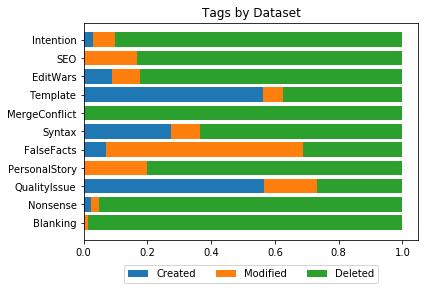

<Figure size 432x288 with 0 Axes>

In [10]:
tag_counts = combined.sum(axis=1)
relative_counts = combined.divide(tag_counts, axis=0)
plot_hbars(relative_counts,
           'Tags by Dataset',
           'hbar_relative_tags_by_dataset')

Attempt a balanced view given the different vandalism rates in c, m, d.
First find out, what was the proportion of the tag given the dataset, e.g.,
x% of the created set have been an edit war.
Second, compare the tag rates with the other datasets.
Read: it was much more likely to encounter a Template vandalism in the 
created than in deleted set.

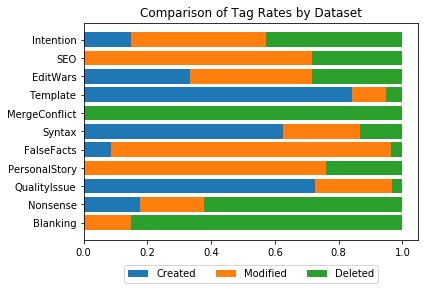

<Figure size 432x288 with 0 Axes>

In [11]:
relative_to_dataset = combined / combined.sum()
relative_sums = relative_to_dataset.sum(axis=1)
relative_to_dataset_and_tag = relative_to_dataset.divide(relative_sums, axis=0)

plot_hbars(relative_to_dataset_and_tag,
           'Comparison of Tag Rates by Dataset',
           'hbar_tag_rate_comparison')

/Users/falco/.local/share/virtualenvs/notebooks-Ad9Pllzq/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


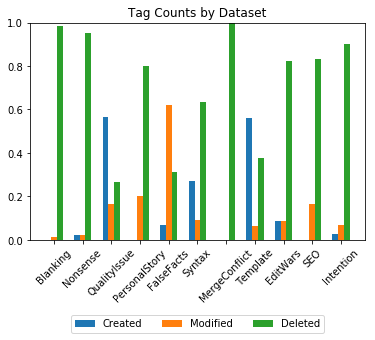

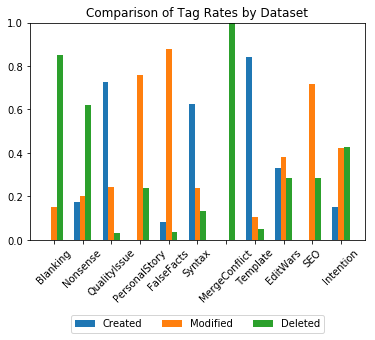

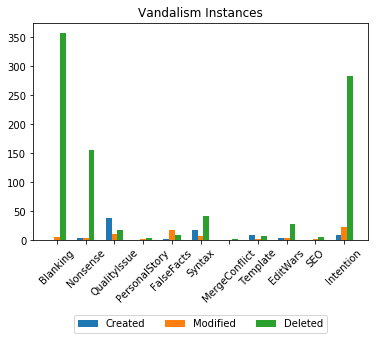

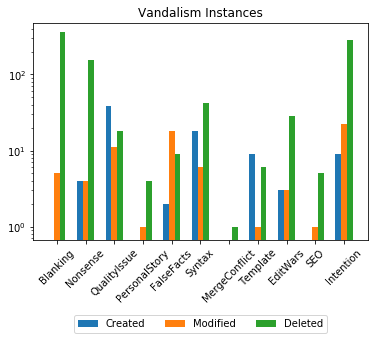

<Figure size 432x288 with 0 Axes>

In [12]:
def plot_vbars(data, title, export_name, logscale=False, normalized=True):
    plt.title(title)
    
    ax = plt.subplot(111)
    
    bars = []
    w = .1
    pad = .2
    x = np.arange(0,
                  len(tags) * w * 3 + len(tags) * pad, # total width
                  w * 3 + pad)
    
    x2 = x - w
    
    for index, tag in enumerate(data):
        bar = ax.bar(x2 + w * index,
                     data[tag],
                     width=w,
                     align='center',
                     log=logscale)
        
        bars.append(bar)
        
    plt.legend(bars,
               ('Created', 'Modified', 'Deleted'),
               loc='lower center',
               ncol=3,
               bbox_to_anchor=(0.5, -0.45))
    
    plt.xticks(x, tags['name'], rotation=45)
    if normalized:
        plt.ylim(0, 1.0)
    export(export_name)


plot_vbars(relative_counts,
           'Tag Counts by Dataset',
           'vbar_relative_tags_by_dataset')

plot_vbars(relative_to_dataset_and_tag,
           'Comparison of Tag Rates by Dataset',
           'vbar_tag_rate_comparision')

plot_vbars(combined,
           'Vandalism Instances',
           'vbar_vandalism_counts',
           normalized=False)

plot_vbars(combined,
           'Vandalism Instances',
           'vbar_vandalism_counts_log',
           logscale=True,
           normalized=False)

Attempt to plot the real distribution by dataset (meaning many colors encoding
individual tags)

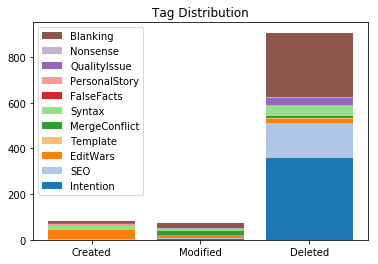

<Figure size 432x288 with 0 Axes>

In [13]:
def plot_stacked(data, title, export_name):
    colors = plt.get_cmap('tab20').colors
    plt.title(title)
    
    last_series = np.repeat(0, len(data))
    bars = []
    for index, column in enumerate(data.columns):
        values = data[column]
        bar = plt.bar(np.arange(len(values)),
                      data[column],
                      bottom=last_series,
                      color = colors[index])
        bars.append(bar)
        last_series += data[column]
    
    plt.legend(bars[::-1], tags['name'])
    plt.xticks(np.arange(3),
              ['Created', 'Modified', 'Deleted'])
    export(export_name)

plot_stacked(combined.T, 'Tag Distribution', 'tag_distribution')

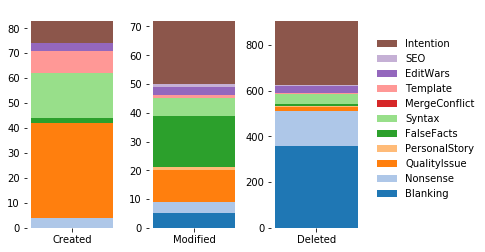

<Figure size 432x288 with 0 Axes>

In [14]:
def plot_multi():
    colors = plt.get_cmap('tab20').colors
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3) 
    sns.despine(fig, left=True, bottom=True)#, top=True, right=True)
    
    def plot(label, data, ax):
        last_value = 0
        bars = []
        for index, (tag, count) in enumerate(zip(data.index, data)):
            bar = ax.bar([label],
                  count,
                  bottom=last_value,
                  color=colors[index])
            last_value += count
            bars.append(bar)
        return bars
    
    plot('Created', created_tag_count, ax1)
    plot('Modified', modified_tag_count, ax2)
    bars = plot('Deleted', deleted_tag_count, ax3)
        
    fig.subplots_adjust(wspace=0.35)
    plt.legend(bars[::-1],
               tags.name[::-1],
               bbox_to_anchor=(2.35, 0.5),
               loc='right',
               frameon=False)
    export('multi', png=True)

plot_multi()

In [15]:
from collections import OrderedDict

def find_co(frame):
    by_revision = frame[frame['tag_id'] != 12].groupby('revision_id')
    revision_to_tags = by_revision.apply(lambda x: tuple(x.tag_id.sort_values()))
    counts = revision_to_tags.value_counts().sort_values(ascending=False)
    return OrderedDict({tags: count for tags, count in counts.items() if len(tags) >= 2 and count > 1})

def plot_co(co):
    for tag_group, count in co.items():
        tag_names = [tags.loc[tag_id]['name'] for tag_id in tag_group]
        print(tag_names, count)

plot_co(find_co(created))
print()
plot_co(find_co(modified))
print()
plot_co(find_co(deleted))

['QualityIssue', 'Template'] 3
['Nonsense', 'Syntax', 'Intention'] 2
['QualityIssue', 'Syntax'] 2

['FalseFacts', 'Intention'] 10
['Nonsense', 'Intention'] 3
['QualityIssue', 'Intention'] 2
['Blanking', 'Intention'] 2

['Blanking', 'Nonsense', 'Intention'] 144
['Blanking', 'Intention'] 96
['Blanking', 'EditWars'] 13
['Blanking', 'EditWars', 'Intention'] 8
['Blanking', 'QualityIssue'] 5
['Nonsense', 'Intention'] 4
['Syntax', 'Intention'] 4
['FalseFacts', 'Intention'] 3
['Blanking', 'QualityIssue', 'Intention'] 3
['Blanking', 'SEO', 'Intention'] 3
['Blanking', 'Nonsense', 'PersonalStory', 'Intention'] 2
['Blanking', 'FalseFacts', 'Intention'] 2
['Blanking', 'Syntax'] 2
['FalseFacts', 'Syntax', 'Intention'] 2
['Blanking', 'PersonalStory', 'Intention'] 2
